In [123]:
# def calculate_test_stat(T_0, E_1, E_2, best_m, T, C, D, m1, m2, num_iter):
#     if len(E_1) == 0:
#         T_1 = T_0.copy()
# 
#     else:
#         T_1 = iterate_algorithm(T_0, E_1, num_iter)
# 
#     T_2 = iterate_algorithm(T_0, E_2, num_iter)
# 
#     # TODO: Delete those plots
# 
#     frequences = np.arange(T_0.shape[2])
#     T_2_inv = invert_spectral_matrix(T_2, 0)
#     T_1_inv = invert_spectral_matrix(T_1, 0)
#     plot_sdf_with_theoretical_plt(frequences, T_2_inv, T_1_inv, title=f"{E_1} vs {E_2} inverse")
#     plot_sdf_with_theoretical_plt(frequences, T_2, T_1, title=f"{E_1} vs {E_2} normal")
# 
# 
#     test_stat = test_statistic(T_1, T_2, T, best_m, D, m1, m2, C)
#     return T_1, T_2, test_stat

In [146]:
from app_hawkes import *
import numpy as np


def plot_sdf_with_theoretical_plt(frequencies, empirical_sdf, theoretical_sdf, log_scale=False,
                              title='Spectral Matrix with Theoretical Spectrum'):
    """
    Plot the SDF for each pair of dimensions with theoretical spectrum.

    Parameters:
    frequencies (np.ndarray): Array of frequency values.
    empirical_sdf (np.ndarray): Empirical spectral density function matrix.
    theoretical_sdf (np.ndarray): Theoretical spectral density function matrix.
    title (str): Title of the plot.
    log_scale (bool): If True, use logarithmic scale for the y-axis.
    """
    # Calculate the length of the spectral density functions
    length = empirical_sdf.shape[2]

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))

    for i in range(5):
        for j in range(5):
            if i != j:
                axes[i, j].plot(frequencies, np.abs(empirical_sdf[i, j, :]), label='Empirical')
                axes[i, j].plot(frequencies, np.abs(theoretical_sdf[i, j, :]), label='Theoretical', linestyle='--')
                axes[i, j].set_title(f'S_{i + 1}{j + 1}')
            else:
                axes[i, j].plot(frequencies, np.abs(empirical_sdf[i, j, :]), label='Empirical')
                axes[i, j].plot(frequencies, np.abs(theoretical_sdf[i, j, :]), label='Theoretical', linestyle='--')
                axes[i, j].set_title(f'S_{i + 1}{i + 1}')

            if log_scale:
                axes[i, j].set_yscale('log')

            if i == 4:
                axes[i, j].set_xlabel('Frequency (Hz)')
            if j == 0:
                axes[i, j].set_ylabel('Spectral Density')

            axes[i, j].grid(True)
            axes[i, j].legend()

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
	
# Constants
C = 0.617
D = 0.446
# D = 0.761
m1 = 0
m2 = 1
num_iter = 10
alpha = 0.05
T = 102400

# A_list = [np.array([
#     [0.5, 0.0, 0.2],
#     [0.0, 0.5, 0.2],
#     [0.2, 0.2, 0.5]
# ])]

# A_list = [np.array([
#     [0.5, 0.0, 0.0, 0.0, 0.0],
#     [0.0, 0.5, 0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.5, 0.0, 0.0],
#     [0.0, 0.0, 0.0, 0.5, 0.0],
#     [0.0, 0.0, 0.0, 0.0, 0.5]
#     ])]
# 
# is_var_process_stationary(A_list)


X = 0.0
# 
A_list = [np.array([
    [0.2, 0.0, 0.3, 0.0, 0.3],
    [0.3, -0.2, X, 0.0, 0.0],
    [0.2, X, 0.3, 0.0, 0.0],
    [0.2, 0.2, 0.0, 0.3, 0.0],
    [0.2, 0.0, 0.2, 0.2, 0.2]
])]

# A_list = [np.array([
#     [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#     [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0],
#     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0],
#     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]
#     ])]


In [147]:
from joblib import Parallel, delayed
from tqdm import tqdm

def process_item(item, brut_test=False, bayesian_test=False, m=100):
    # Generate time series
    x = generate_var_process(A_list, T, 1000, seed=None)
    x = x - np.mean(x, axis=1, keepdims=True)
    
    
    if brut_test:
        m_range = np.arange(1000, 10000, 1000)
        cvll_values, m = find_best_m(x, m_range)
        plot_cvll_criterion(m_range, cvll_values, m)
        
    if bayesian_test:
    
        m_results = bayesian_search_cvll(x, T)
    
        if int(m_results.x[0]) % 2 != 0:
            m = m_results.x[0] + 1
        else:
            m = m_results.x[0]
    
        _ = plot_gaussian_process(m_results)
        # Display the plot in Streamlit
        plt.show()
    
    _, T_0_mirror, frequencies = calculate_freq_avg_periodogram_mirrored(x, m)
    
    _, T_0_gregg, _ = calculate_freq_avg_periodogram(x, m)
    
    # _, T_0_test, _ = calculate_freq_avg_periodogram_mirrored(x, 20)
    # fig = plot_sdf_with_theoretical(frequencies, [T_0_mirror, T_0_gregg, T_0_test], ['Mirror', 'Gregg', 'test'], None)
    # 
    # fig.show()
    
    # all_edge_removed = set()
    all_edge_removed = {(1,4)}
    
    E = {(1,2)} | all_edge_removed
    
    _, _, test_stat_mirror = calculate_test_stat(T_0_mirror, all_edge_removed, E, m,
                                                              T, C, D, m1, m2, num_iter)
    
    _, _, test_stat_gregg =calculate_test_stat(T_0_gregg, all_edge_removed, E, m,
                                                              T, C, D, m1, m2, num_iter)
    return test_stat_mirror, test_stat_gregg, m

In [150]:
process_item("item", brut_test=False, bayesian_test=False, m=10000)

(np.complex128(-0.23831041036126874+1.6922247355923213e-17j),
 np.complex128(-0.4038371550810928+3.4661869075361257e-17j),
 10000)

In [141]:
num_simulations = 2000

items = range(num_simulations)  # Example list of items to process


# Parallelize the for loop
results = Parallel(n_jobs=-1)(delayed(process_item)(item, brut_test=True) for item in tqdm(items, desc="Processing items"))

Processing items:   0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (5,5,512) (513,) 

In [81]:
# Separate the list of tuples into individual lists
test_stats, test_stats_greg, m_values = zip(*results)

# Convert the zipped objects to lists
test_stats = np.real(list(test_stats))
test_stats_greg = np.real(list(test_stats_greg))
m_values = list(m_values)

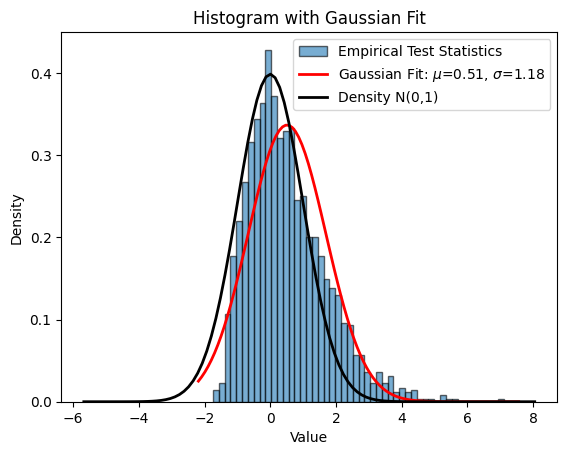

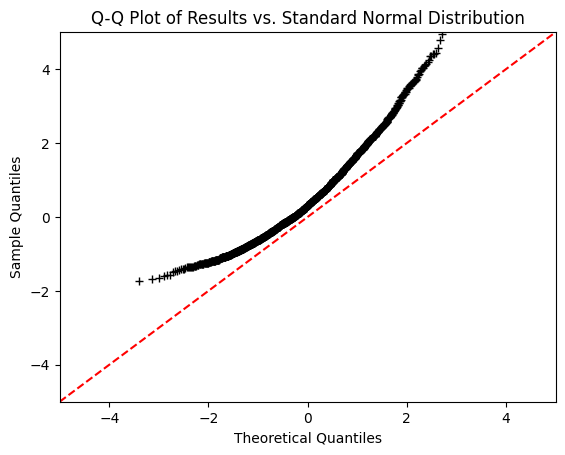

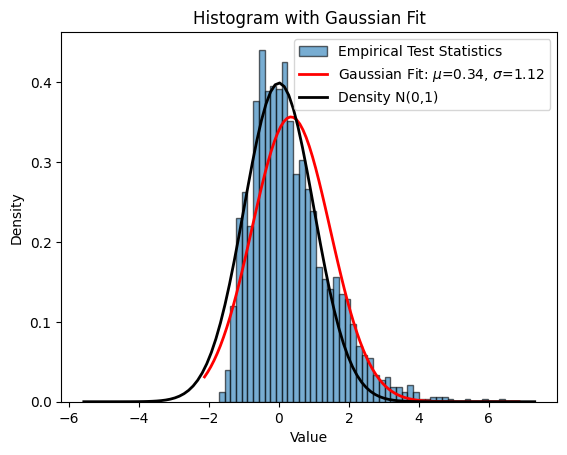

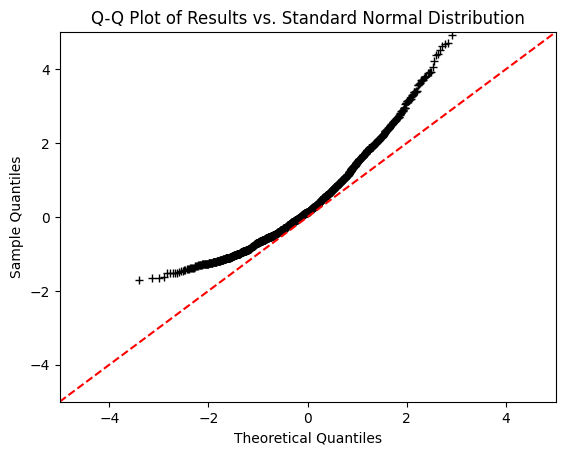

Mirror power:  0.167
Gregg power:  0.1335


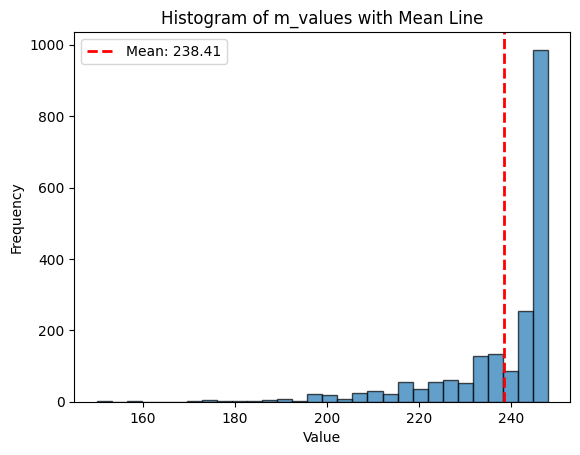

Skewness of the data: 0.95
The distribution is positively skewed (right tail is longer).


In [82]:
import numpy as np
from scipy.stats import norm, probplot


def plot_test_stats_simulations(test_stats):
    mean_result = np.mean(test_stats)
    std_result = np.std(test_stats)
    # Plot a histogram of the results
    plt.hist(test_stats, bins=50, edgecolor='black', density=True, alpha=0.6, label='Empirical Test Statistics')
    # Plot the Gaussian distribution using mean and std from the data
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_result, std_result)
    plt.plot(x, p, 'r', linewidth=2, label=f'Gaussian Fit: $\mu$={mean_result:.2f}, $\sigma$={std_result:.2f}')
    # Add a line representing the density of a normal distribution (mean=0, std=1)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin - 3, xmax, 100)
    p = norm.pdf(x, 0, 1)
    plt.plot(x, p, 'k', linewidth=2, label=f'Density N(0,1)')
    # Add titles, labels, and legend
    plt.title('Histogram with Gaussian Fit')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    # Show the plot
    plt.show()
    # Q-Q plot of results vs. standard normal distribution
    plt.figure()
    probplot(test_stats, dist="norm", plot=plt, fit=False)
    
    
    # Customize the Q-Q plot to use black crosses for the scatter points
    plt.gca().get_lines()[0].set_marker('+')
    plt.gca().get_lines()[0].set_markerfacecolor('black')
    plt.gca().get_lines()[0].set_markeredgecolor('black')
    
    
    # Add titles and labels to the Q-Q plot
    plt.title('Q-Q Plot of Results vs. Standard Normal Distribution')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    # Set x and y-axis limits
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    # Plot a manual red line from (-5, -5) to (5, 5)
    plt.plot([-5, 5], [-5, 5], 'r--')
    # Show the Q-Q plot
    plt.show()
    
def plot_m(m_values):
    # Plot the histogram
    plt.hist(m_values, bins=30, edgecolor='black', alpha=0.7)
    # Calculate the mean
    mean_value = np.mean(m_values)
    # Add a vertical line at the mean
    plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    # Add titles and labels
    plt.title('Histogram of m_values with Mean Line')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    # Show the plot
    plt.show()


plot_test_stats_simulations(test_stats)
plot_test_stats_simulations(test_stats_greg)


print("Mirror power: ", np.sum(test_stats > 1.646)/len(test_stats))
print("Gregg power: ", np.sum(test_stats_greg > 1.646)/len(test_stats_greg))

plot_m(m_values)

# Calculate the skewness
skewness = stats.skew(test_stats)

# Print the skewness
print(f'Skewness of the data: {skewness:.2f}')

# Compare with standard normal distribution
if skewness == 0:
    print("The distribution is symmetrical (similar to a standard normal distribution).")
elif skewness > 0:
    print("The distribution is positively skewed (right tail is longer).")
else:
    print("The distribution is negatively skewed (left tail is longer).")

In [83]:
import os
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Test_Stat_Mirror', 'Test_Stat_Gregg', 'm'])

# Create the simulations_data directory if it doesn't exist
output_dir = '../simulations_data'
os.makedirs(output_dir, exist_ok=True)

size = A_list[0].shape[0]



# Save the DataFrame as a CSV file in the simulations_data directory
output_file = os.path.join(output_dir, f'{size}x{size}_simulations={num_simulations}_m={None}_T={T}_independent.csv')
results_df.to_csv(output_file, index=False)


Processing items: 100%|██████████| 2000/2000 [03:18<00:00, 10.06it/s]


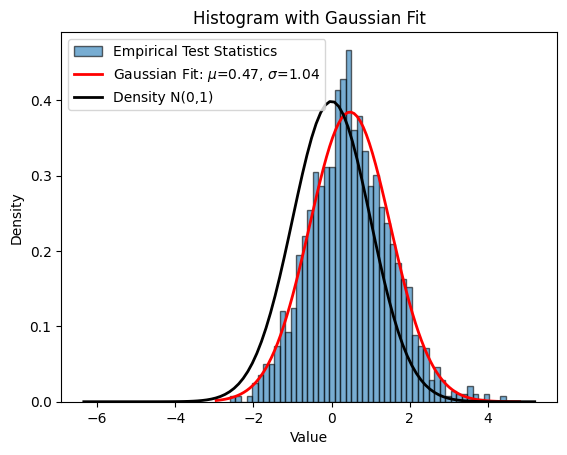

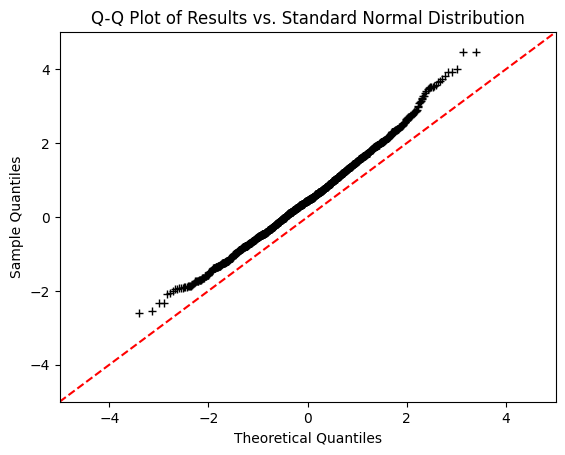

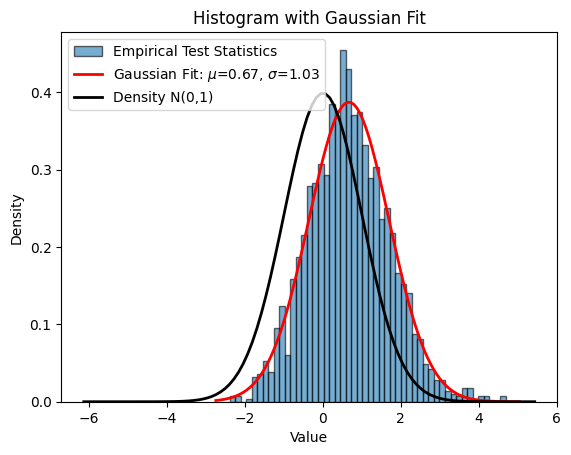

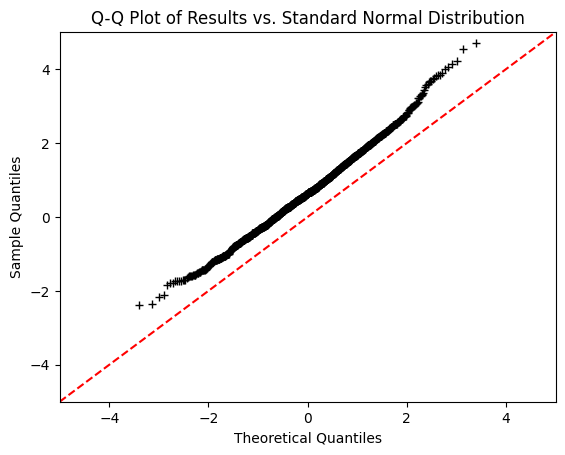

Mirror power:  0.13
Gregg power:  0.1705
Skewness of the data: 0.24
The distribution is positively skewed (right tail is longer).



Processing items: 100%|██████████| 2000/2000 [03:55<00:00,  8.51it/s]


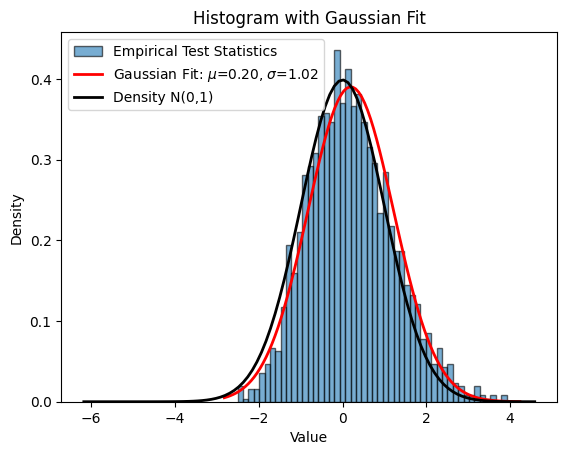

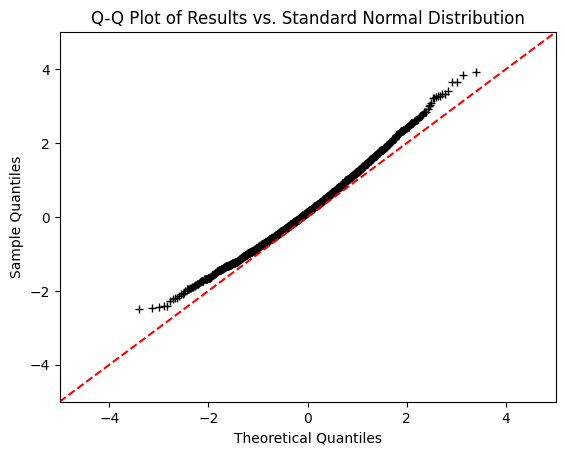

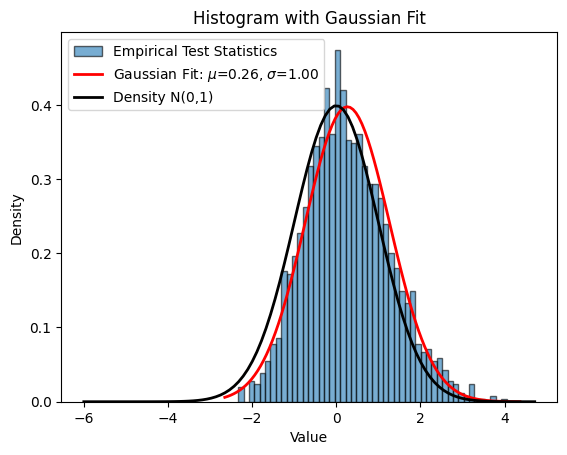

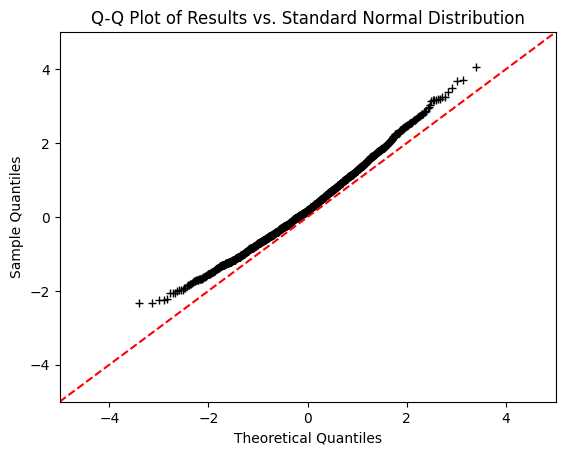

Mirror power:  0.0875
Gregg power:  0.0955
Skewness of the data: 0.35
The distribution is positively skewed (right tail is longer).



Processing items: 100%|██████████| 2000/2000 [04:12<00:00,  7.92it/s]


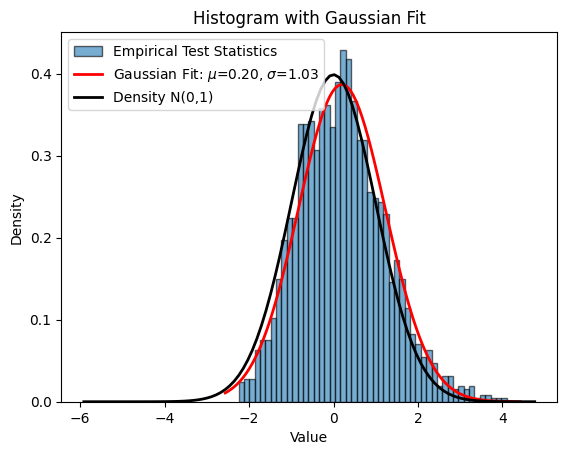

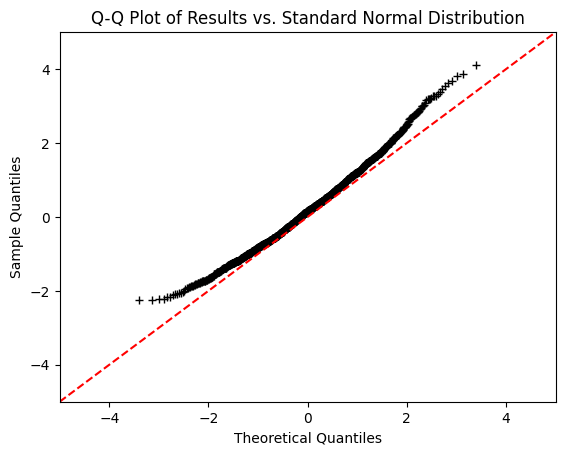

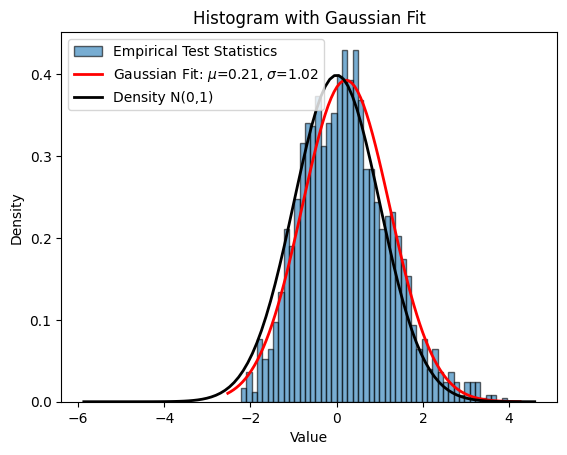

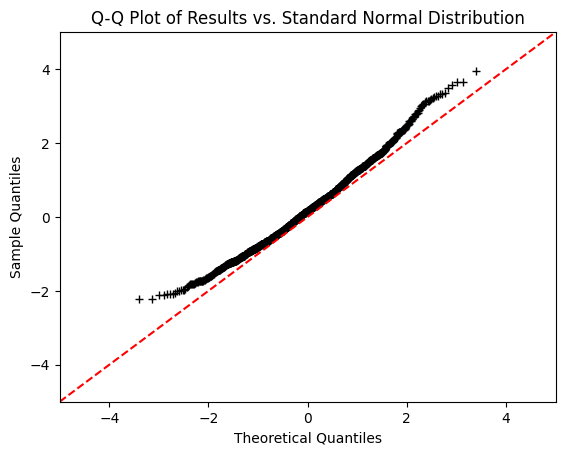

Mirror power:  0.0835
Gregg power:  0.0845
Skewness of the data: 0.41
The distribution is positively skewed (right tail is longer).



Processing items: 100%|██████████| 2000/2000 [05:03<00:00,  6.60it/s]


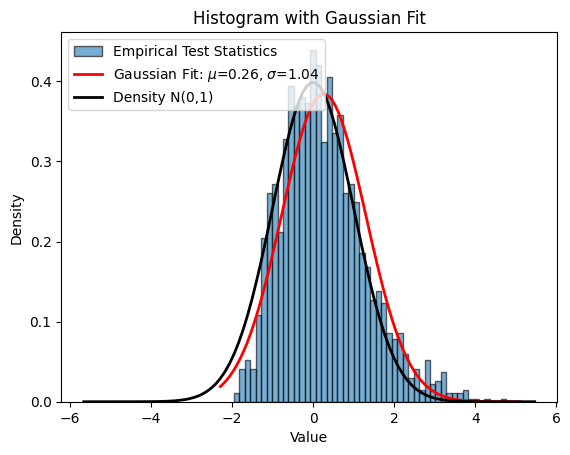

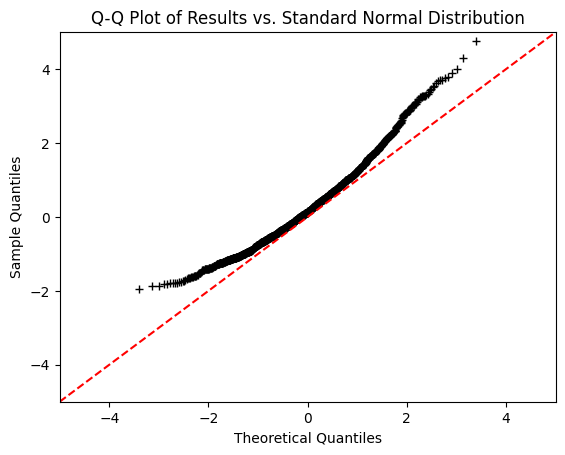

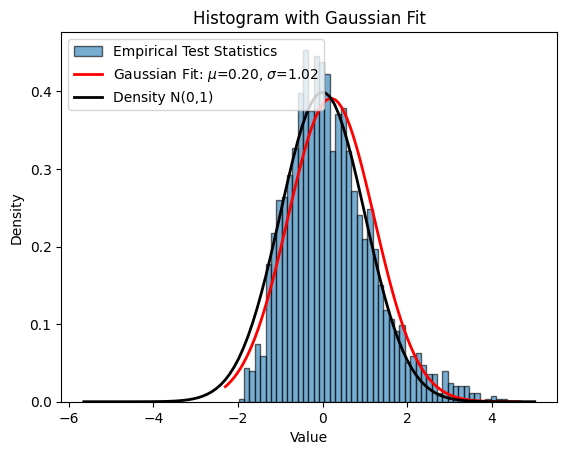

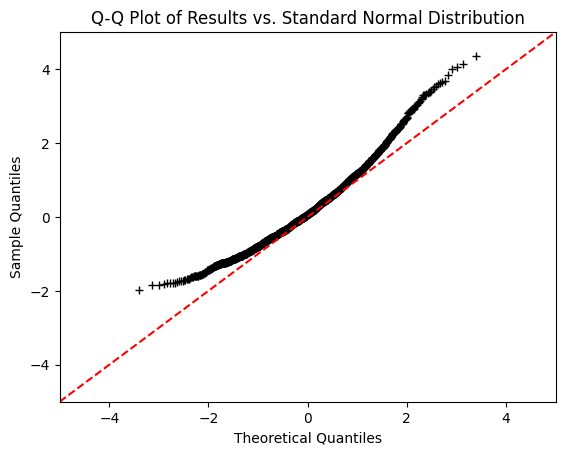

Mirror power:  0.101
Gregg power:  0.087
Skewness of the data: 0.70
The distribution is positively skewed (right tail is longer).



Processing items: 100%|██████████| 2000/2000 [05:53<00:00,  5.65it/s]


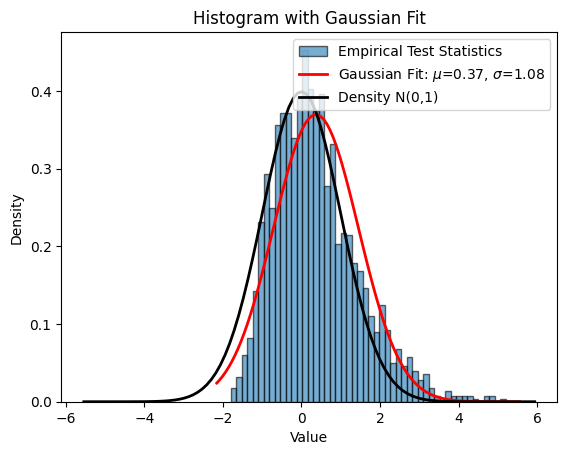

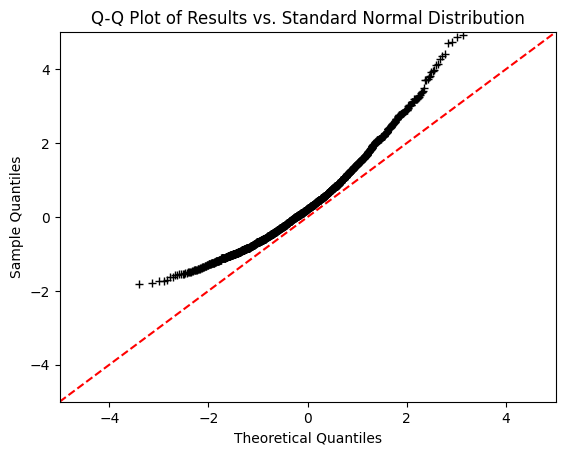

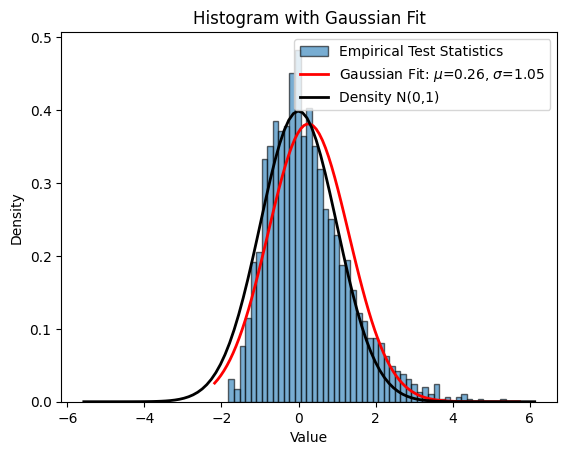

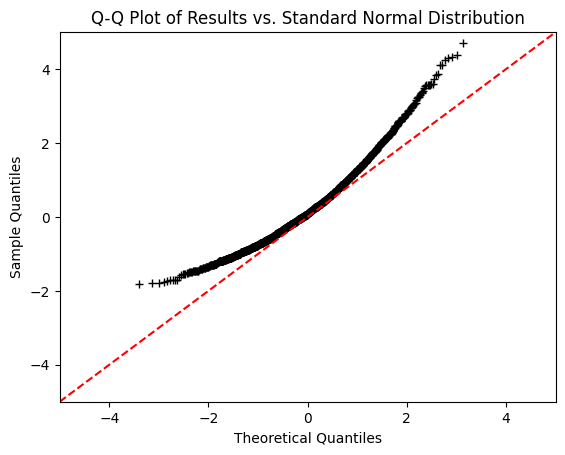

Mirror power:  0.1225
Gregg power:  0.1035
Skewness of the data: 0.84
The distribution is positively skewed (right tail is longer).



Processing items: 100%|██████████| 2000/2000 [06:59<00:00,  4.76it/s]


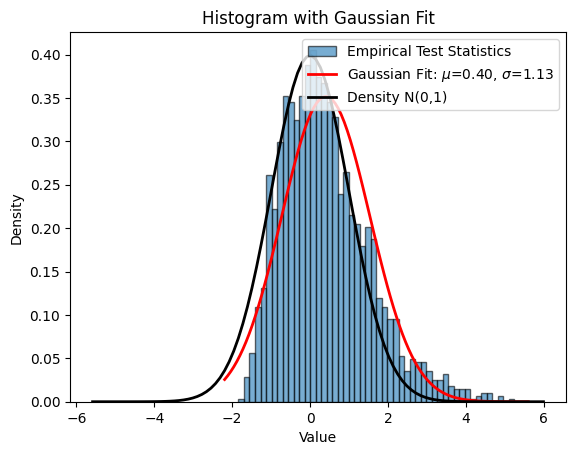

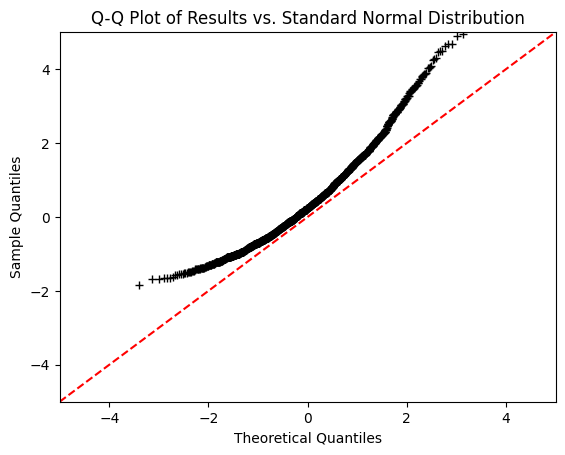

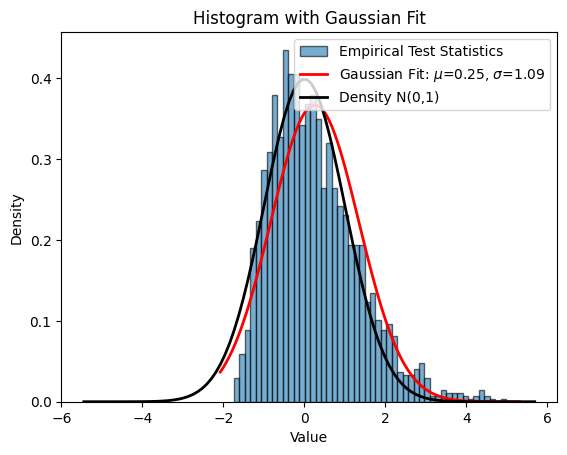

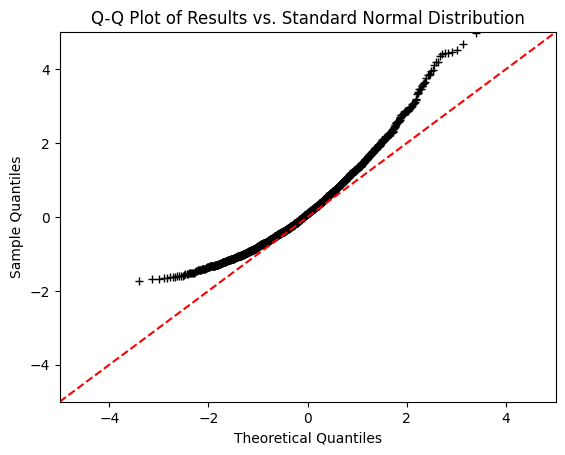

Mirror power:  0.1355
Gregg power:  0.11
Skewness of the data: 0.87
The distribution is positively skewed (right tail is longer).


In [87]:
m_list = [100, 300, 500, 1000, 1500, 2000]
num_simulations = 2000


X = 0.0
# 
A_list = [np.array([
    [0.2, 0.0, 0.3, 0.0, 0.3],
    [0.3, -0.2, X, 0.0, 0.0],
    [0.2, X, 0.3, 0.0, 0.0],
    [0.2, 0.2, 0.0, 0.3, 0.0],
    [0.2, 0.0, 0.2, 0.2, 0.2]
])]

# Constants
C = 0.617
D = 0.446
# D = 0.761
m1 = 0
m2 = 1
num_iter = 10
alpha = 0.05
T = 1024

# Create the simulations_data directory if it doesn't exist
output_dir = '../simulations_data'
os.makedirs(output_dir, exist_ok=True)

size = A_list[0].shape[0]


for m in m_list:
    items = range(num_simulations)  # Example list of items to process
    # Parallelize the for loop
    results = Parallel(n_jobs=-1)(delayed(process_item)(item, brut_test=False, m=m) for item in tqdm(items, desc="Processing items"))
    
    # Separate the list of tuples into individual lists
    test_stats, test_stats_greg, m_values = zip(*results)
    
    # Convert the zipped objects to lists
    test_stats = np.real(list(test_stats))
    test_stats_greg = np.real(list(test_stats_greg))
    m_values = list(m_values)
    
    plot_test_stats_simulations(test_stats)
    plot_test_stats_simulations(test_stats_greg)
    
    
    print("Mirror power: ", np.sum(test_stats > 1.646)/len(test_stats))
    print("Gregg power: ", np.sum(test_stats_greg > 1.646)/len(test_stats_greg))
    
    # Calculate the skewness
    skewness = stats.skew(test_stats)
    
    # Print the skewness
    print(f'Skewness of the data: {skewness:.2f}')
    
    # Compare with standard normal distribution
    if skewness == 0:
        print("The distribution is symmetrical (similar to a standard normal distribution).")
    elif skewness > 0:
        print("The distribution is positively skewed (right tail is longer).")
    else:
        print("The distribution is negatively skewed (left tail is longer).")
        
    # Convert results to DataFrame
    results_df = pd.DataFrame(results, columns=['Test_Stat_Mirror', 'Test_Stat_Gregg', 'm'])
    
    
    # Save the DataFrame as a CSV file in the simulations_data directory
    output_file = os.path.join(output_dir, f'{size}x{size}_simulations={num_simulations}_m={m}_T={T}_independent.csv')
    results_df.to_csv(output_file, index=False)
    
    

In [100]:
import os
from collections import defaultdict

def categorize_files_first_algorithm(files, n):
    categories = defaultdict(lambda: defaultdict(list))
    n_str = f"{n}x{n}"

    for file_name in files:
        if n_str not in file_name:
            continue
        
        parts = file_name.split('_')
        
        # Extracting m and T values
        m_part = [part for part in parts if part.startswith('m=')][0]
        T_part = [part for part in parts if part.startswith('T=')][0]
        type_part = 'independentcon' if 'independentcon' in file_name else 'independent'
        
        m_value = m_part.split('=')[1]
        T_value = T_part.split('=')[1]

        # Constructing dictionary keys
        m_key = m_value
        T_key = f"T={T_value}"
        
        # Adding file to appropriate category
        categories[type_part][T_key].append({m_key: file_name})
    
    return dict(categories)

def get_all_files(directory):
    # List all files in the given directory
    file_list = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return file_list

# Directory path
directory_path = '../simulations_data'

# Get all files from the directory
file_list = get_all_files(directory_path)

# Categorize the files
organized_files = categorize_files_first_algorithm(file_list, 5)


In [101]:
organized_files

{'independent': defaultdict(list,
             {'T=1024': [{'250': '../simulations_data/5x5_simulations=2000_m=250_T=1024_independent.csv'},
               {'100': '../simulations_data/5x5_simulations=2000_m=100_T=1024_independent.csv'},
               {'500': '../simulations_data/5x5_simulations=2000_m=500_T=1024_independent.csv'},
               {'None': '../simulations_data/5x5_simulations=2000_m=None_T=1024_independent.csv'},
               {'200': '../simulations_data/5x5_simulations=2000_m=200_T=1024_independent.csv'},
               {'50': '../simulations_data/5x5_simulations=2000_m=50_T=1024_independent.csv'},
               {'20': '../simulations_data/5x5_simulations=2000_m=20_T=1024_independent.csv'},
               {'300': '../simulations_data/5x5_simulations=2000_m=300_T=1024_independent.csv'}],
              'T=10240': [{'2000': '../simulations_data/5x5_simulations=2000_m=2000_T=10240_independent.csv'},
               {'500': '../simulations_data/5x5_simulations=2000_m=500

In [105]:
def filter_files_with_m_none(organized_files_independent):
    filtered_files = {}
    
    for T_key, m_files in organized_files_independent.items():
        for m_file_dict in m_files:
            for m_key, file_path in m_file_dict.items():
                if m_key == 'None':
                    filtered_files[T_key] = file_path
                    break
    
    return filtered_files

filtered_files = filter_files_with_m_none(organized_files['independent'])
filtered_files

{'T=1024': '../simulations_data/5x5_simulations=2000_m=None_T=1024_independent.csv'}

In [108]:
def split_filename(path):
    # Extract the filename from the path
    filename = path.split("/")[-1]

    # Split the filename on "_"
    parts = filename.split("_")

    # Extract the number of time series from the first part
    num_time_series = int(parts[0].split("x")[0])

    # Extract the number of simulations from the second part
    num_simulations = int(parts[1].split("=")[1])

    # Extract T value from the second to last part
    T = int(parts[-2].split("=")[1])

    # Extract m value from the third to last part
    m_value_part = parts[-3].split("=")[1]
    if m_value_part == 'None':
        m_value = None
    else:
        m_value = int(m_value_part)

    return num_time_series, num_simulations, T, m_value


In [109]:
split_filename(filtered_files['T=1024'])

(5, 2000, 1024, None)

In [115]:
print(list(filtered_files.keys())[0])

T=1024


In [121]:
def rename_matsuda_csv_columns(directory):
    matsuda_data = []
    
    # Loop through all files in the specified directory
    for file_name in os.listdir(directory):
        if 'matsuda' in file_name and file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            # Rename the columns
            df.columns = ['Test_Stat_Mirror', 'Test_Stat_Gregg', 'm']
            
            # Append the DataFrame to the list
            matsuda_data.append(file_name)
            
            # Optionally, save the renamed DataFrame back to CSV (uncomment if needed)
            df.to_csv(file_path, index=False)
    
    return matsuda_data

In [122]:
rename_matsuda_csv_columns('../simulations_data')

['5x5_simulations=2000_m=150_T=401_matsuda.csv',
 '5x5_simulations=2000_m=20_T=201_matsuda.csv',
 '5x5_simulations=2000_m=76_T=201_matsuda.csv',
 '5x5_simulations=2000_m=1500_T=10240_matsuda.csv',
 '5x5_simulations=2000_m=50_T=401_matsuda.csv',
 '5x5_simulations=2000_m=100_T=401_matsuda.csv',
 '5x5_simulations=2000_m=50_T=201_matsuda.csv',
 '5x5_simulations=2000_m=100_T=10240_matsuda.csv',
 '5x5_simulations=2000_m=20_T=401_matsuda.csv',
 '5x5_simulations=2000_m=1000_T=10240_matsuda.csv']